In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from sklearn import model_selection
from PIL import Image, ImageFilter

In [3]:
training_names = []
test_names = []
testing_sites = ['OL', 'LL', 'C8', 'BH', 'AR', 'A7', 'A1']
rgbs_dir = '/content/drive/MyDrive/Biomedical Imaging Project/rgbs_colorNormalized'
masks_dir = '/content/drive/MyDrive/Biomedical Imaging Project/masks'

In [4]:
for filename in os.listdir(rgbs_dir):
    if filename[5:7] in testing_sites :
      test_names += [filename]
    else :
      training_names += [filename]

train_names, val_names = model_selection.train_test_split(training_names,test_size=20,
                                                          train_size=62,
                                                          random_state=7)

filenames = {'train': train_names, 'val': val_names}

In [24]:
rgb_name = os.path.join(rgbs_dir, filenames['train'][0])
mask_name = os.path.join(masks_dir, filenames['train'][0])

rgb = Image.open(rgb_name)
mask = Image.open(mask_name).convert('I;16')
trans = transforms.Compose([
    transforms.ToTensor()])
rgb_tensor_old = trans(rgb)
rgb_tensor = rgb_tensor_old.permute(1,2,0)
mask_tensor = trans(mask)
mask_tensor = mask_tensor.permute(1,2,0)
rgb_array = rgb_tensor.numpy()
#rgb_blurred_array = cv2.GaussianBlur(rgb_array, (5,5),5,5)
rgb_blurred_array = cv2.GaussianBlur(rgb_array, (9,9),5,5,cv2.BORDER_DEFAULT)
mask_array = mask_tensor.numpy()

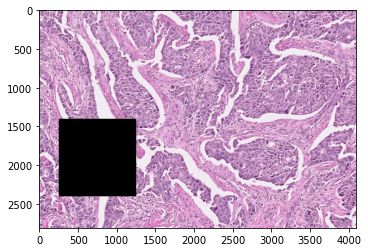

In [25]:
import random
def crop(image):
  #gets coordinates to find the random patch for 
  #augmentations
  height = image.shape[0]
  width = image.shape[1]
  corner_height = random.randrange(height - 1000)
  corner_width = random.randrange(width - 1000)
  return corner_height, corner_width

def cut_blur(img,img_blur):
  #Given the original image and blurred image 
  #Returns cut blurred version of both the original
  #image and blurred image
  corner_height, corner_width = crop(img)
  hold = img[corner_height:corner_height + 1000, corner_width:corner_width + 1000,:]
  hold_blur = img_blur[corner_height:corner_height + 1000, corner_width:corner_width + 1000,:]
  #image = img.numpy()
  final_img = np.copy(img)
  final_blur = np.copy(img_blur)
  final_img[corner_height:corner_height + 1000, corner_width:corner_width + 1000,:] = hold_blur
  img_blur[corner_height:corner_height + 1000, corner_width:corner_width + 1000,:] = hold
  return final_img, img_blur

def cut_out(img):
  #Given an image cuts out a random patch and fills the values with 0
  corner_height, corner_width = crop(img)
  hold = img[corner_height:corner_height + 1000, corner_width:corner_width + 1000,:]
  final_image = np.copy(img)
  final_image[corner_height:corner_height + 1000, corner_width:corner_width + 1000,:] = np.zeros(hold.shape)
  return final_image
  


HR_blur_crop, LR_high_crop = cut_blur(rgb_array, rgb_blurred_array)
cutout = cut_out(rgb_array)

plt.imshow(cutout)
plt.show()

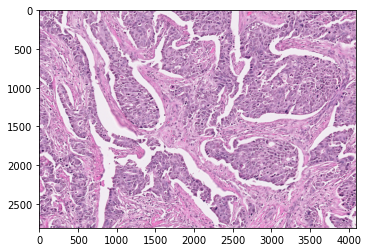

In [26]:
plt.imshow(HR_blur_crop)
plt.show()

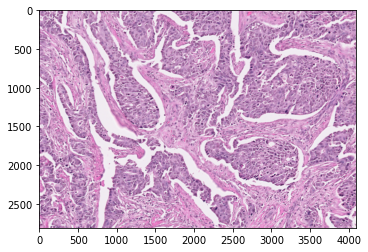

In [27]:
plt.imshow(LR_high_crop)
plt.show()

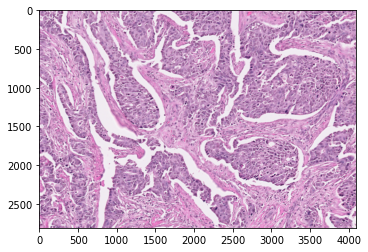

In [28]:
plt.imshow(rgb_blurred_array)
plt.show()

In [ ]:
#Create dictionary of augmented data points 
augmented = {'rgb': [], 'mask': []}
#Run through all images in the current training file
for i in range(len(filenames['train'])):
  rgb_name = os.path.join(rgbs_dir, filenames['train'][0])
  mask_name = os.path.join(masks_dir, filenames['train'][0])
  #Set up images so that they can be operated on
  rgb = Image.open(rgb_name)
  mask = Image.open(mask_name).convert('I;16')
  trans = transforms.Compose([
    transforms.ToTensor()])
  rgb_tensor_old = trans(rgb)
  rgb_tensor = rgb_tensor_old.permute(1,2,0)
  mask_tensor = trans(mask)
  mask_tensor = mask_tensor.permute(1,2,0)
  rgb_array = rgb_tensor.numpy()
  rgb_blurred_array = cv2.GaussianBlur(rgb_array, (5,5),0,0)
  mask_array = mask_tensor.numpy()
  #Perform data augmentations from the functions above
  HR_blur_crop, LR_high_crop = cut_blur(rgb_array, rgb_blurred_array)
  cutout = cut_out(rgb_array)
  #Change numpy arrays to PIL Images 
  augmented_cutblur1 = Image.fromarray(np.uint8(HR_blur_crop*255))
  augmented_cutblur2 = Image.fromarray(np.uint8(LR_high_crop*255))
  augmented_cutout = Image.fromarray(np.uint8(cutout*255))
  #Add images to the augmented dictionary with 
  #their respective mask added for each instance
  #(since there are three augmentations for one training image
  #we add three of the same mask
  augmented['rgb'].append(augmented_cutblur1)
  augmented['rgb'].append(augmented_cutblur2)
  augmented['rgb'].append(augmented_cutout)
  augmented['mask'].append(mask)
  augmented['mask'].append(mask)
  augmented['mask'].append(mask)

print(augmented)
  



{'rgb': [<PIL.Image.Image image mode=RGB size=4093x2812 at 0x7FB0ADF48E90>, <PIL.Image.Image image mode=RGB size=4093x2812 at 0x7FB0ADF48E10>, <PIL.Image.Image image mode=RGB size=4093x2812 at 0x7FB0AFD9DFD0>, <PIL.Image.Image image mode=RGB size=4093x2812 at 0x7FB0ADF49050>, <PIL.Image.Image image mode=RGB size=4093x2812 at 0x7FB0AFC92DD0>, <PIL.Image.Image image mode=RGB size=4093x2812 at 0x7FB0ADF48ED0>, <PIL.Image.Image image mode=RGB size=4093x2812 at 0x7FB0ADF49250>, <PIL.Image.Image image mode=RGB size=4093x2812 at 0x7FB0ADF49090>, <PIL.Image.Image image mode=RGB size=4093x2812 at 0x7FB0ADF48D90>, <PIL.Image.Image image mode=RGB size=4093x2812 at 0x7FB0AFC56110>, <PIL.Image.Image image mode=RGB size=4093x2812 at 0x7FB0ADF49A50>, <PIL.Image.Image image mode=RGB size=4093x2812 at 0x7FB0ADF49810>, <PIL.Image.Image image mode=RGB size=4093x2812 at 0x7FB0AFCA8150>, <PIL.Image.Image image mode=RGB size=4093x2812 at 0x7FB0ADF49310>, <PIL.Image.Image image mode=RGB size=4093x2812 at 0x7